In [2]:
import base64, os
import multihash as mh
import hashlib as hl  
from dataclasses import dataclass

## Kademlia key implementation taken from https://github.com/libp2p/py-libp2p-xor/blob/master/key/key.py

In [2]:
# bits_in_byte returns a list of bits in a byte, in descending order of significance.
def bits_in_byte(byte):
    return [
        byte & 0x80 != 0,
        byte & 0x40 != 0,
        byte & 0x20 != 0,
        byte & 0x10 != 0,
        byte & 0x8 != 0,
        byte & 0x4 != 0,
        byte & 0x2 != 0,
        byte & 0x1 != 0,
    ]


class Key(bytes):
    def bit_len(self):
        return len(self) * 8

    def bit_at(self, offset):
        return self[offset // 8] & (1 << (7 - offset % 8))

    def to_float(self):
        f = 0.0
        s = 1.0
        for byte in self:
            for bit in bits_in_byte(byte):
                s /= 2.0
                if bit:
                    f += s
        return f

    def __eq__(self, other):
        if isinstance(other, Key):
            return self.hex() == other.hex()
        else:
            return False

    def __hash__(self):
        return hash(self.hex())

    def __str__(self):
        return self.hex()


def choose_key(n):
    return Key(bytearray(os.urandom(n)))


def xor_key(x: Key, y: Key):
    return Key(bytes([x[k] ^ y[k] for k in range(len(x))]))


def key_from_base64_kbucket_id_optional(s: str):
    return key_from_base64_kbucket_id(s) if s else None


def key_from_base64_kbucket_id(s: str):
    return Key(base64.b64decode(s))

## Useful helper functions

In [3]:
def bytes_to_bit_string(data: bytes) -> str:
    return "".join(f'{byte:08b}' for byte in data)
  
def multihash_to_kad_id(peer_id: str) -> bytes:  
    multi_hash = mh.from_b58_string(peer_id)
    return hl.sha256(multi_hash).digest()
# this should be a clean way (even if it could be done in less lines it is more readable)
def xor_distance(bytes0: bytes, bytes1: bytes):
    xor=bytearray()
    maxlen=max(len(bytes0), len(bytes1))

    for i in range(maxlen):
        byte0 = bytes0[i if len(bytes0)>len(bytes1) else i-len(bytes1)+len(bytes0)] if i >= maxlen-len(bytes0) else 0
        byte1 = bytes1[i if len(bytes1)>len(bytes0) else i-len(bytes0)+len(bytes1)] if i >= maxlen-len(bytes1) else 0
        xor.append(byte0 ^ byte1)

    return bytes(xor)

# get the corresponding k-bucket for the given XOR distance in bytes
def bucket_number_for_distance(d: bytes) -> int:
    count=0
    # iterate on the bytes from left to right
    for b in d:
        # while the byte==0, add 8 (bits) to the counter
        count+=8
        if b!=0:
            # at the first non null byte, shift right until this byte==0
            while b!=0:
                b>>=1
                # for each right shift, remove 1 to counter
                count-=1
            break
    # return the length of the byte string minus the number of leading 0 bits
    return 8*len(d)-count


##### TESTING METHODS #####

def bitstring_to_bytes(s):
    v = int(s, 2)
    b = bytearray()
    while v:
        b.append(v & 0xff)
        v >>= 8
    return bytes(b[::-1])

## XOR trie implementation taken from https://github.com/libp2p/py-libp2p-xor/blob/master/trie/trie.py

In [4]:
@dataclass
class Trie1:
    branch: (any, any)
    key: Key

    def __init__(self):
        self.branch = (None, None)
        self.key = None

    def is_empty(self):
        return not self.key

    def is_leaf(self):
        return not self.branch[0] and not self.branch[1]

    def is_empty_leaf(self):
        return self.is_empty() and self.is_leaf()

    def is_non_empty_leaf(self):
        return not self.is_empty() and self.is_leaf()

    def size(self):
        return self.size_at_depth(0)

    def size_at_depth(self, depth):
        if self.is_leaf():
            return 0 if self.is_empty() else 1
        else:
            return self.branch[0].size_at_depth(depth + 1) + self.branch[1].size_at_depth(depth + 1)

    def add(self, key):
        return self.add_at_depth(0, key)

    def add_at_depth(self, depth, key):
        if self.is_empty_leaf():
            self.key = key
            return depth, True
        elif self.is_non_empty_leaf():
            if key == self.key:
                # key already in trie
                return depth, False
            else:
                p = self.key
                self.key = None
                self.branch = (Trie(), Trie())
                self.branch[p.bit_at(depth)].key = p
                return self.branch[key.bit_at(depth)].add_at_depth(depth + 1, key)
        else:
            return self.branch[key.bit_at(depth)].add_at_depth(depth + 1, key)

    def remove(self, key):
        return self.remove_at_depth(0, key)

    def remove_at_depth(self, depth, key):
        if self.is_empty_leaf():
            return depth, False
        elif self.is_non_empty_leaf():
            self.key = None
            return depth, True
        else:
            d, removed = self.branch[key.bit_at(depth)].remove_at_depth(depth + 1, key)
            if removed:
                self.shrink()
                return d, True
            else:
                return d, False

    def find(self, key):
        return self.find_at_depth(0, key)

    def find_at_depth(self, depth, key):
        if self.is_empty_leaf():
            return None, depth
        elif self.is_non_empty_leaf():
            return self.key, depth
        else:
            return self.branch[key.bit_at(depth)].find_at_depth(depth + 1, key)

    def list_of_depths(self):
        return self.list_of_depths_at_depth(0)

    def list_of_depths_at_depth(self, depth):
        if self.is_empty_leaf():
            return []
        elif self.is_non_empty_leaf():
            return [depth]
        else:
            l0 = self.branch[0].list_of_depths_at_depth(depth + 1)
            l1 = self.branch[1].list_of_depths_at_depth(depth + 1)
            return l0 + l1

    def shrink(self):
        b0, b1 = self.branch[0], self.branch[1]
        if b0.is_empty_leaf() and b1.is_empty_leaf():
            self.branch = (None, None)
        elif b0.is_empty_leaf() and b1.is_non_empty_leaf():
            self.key = b1.key
            self.branch = (None, None)
        elif b0.is_non_empty_leaf() and b1.is_empty_leaf():
            self.key = b0.key
            self.branch = (None, None)

## Peer class

In [5]:
class Peer(object):

    def __init__(self, index, key, neighbors, buckets, alive):
        self.index = index # not necessary, but convienient to work with Nebula Crawler
        self.key = key
        # neighbors ordered from closer to farthest
        # TODO: or the other way round?
        self.neighbors = neighbors
        # bucket 0 contains the farthest peers (full), high buckets are empty
        # TODO: dictionary?
        self.buckets = buckets
        self.alive = alive
                
    def distance(self, p):
        return xor_key(self.key, p.key)
        


## Nebula Crawler database queries

In [3]:
import psycopg2

# query to connect to the postgresql db
postgres_connect_query="host=127.0.0.1 dbname=nebula user=nebula password=password"
# query to get all peers
get_peers_query="select id,multi_hash from peers;"
# query to retrieve all neighbors relations between peers
get_neighbors_query="select peer_id,neighbor_ids from neighbors where crawl_id=2;"

# indexes in the postgresql peers/neighbors db for multihashes and ids (topo id)
peers_id_col=0       # for both peers and neighbors query results
peers_mh_col=1       # for peers query results
neighbor_ids_col=1   # for neighbors query results


## Query the Nebula DB

In [4]:
# setup connection to postgresql db
conn = psycopg2.connect(postgres_connect_query)
cur = conn.cursor()

# query peers nebulaID and peerID
cur.execute(get_peers_query)
#peer_list = {l[peers_id_col]: [multihash_to_kad_id(l[peers_mh_col]), l[peers_mh_col]] for l in cur.fetchall()}
peer_list = {l[peers_id_col]: l[peers_mh_col] for l in cur.fetchall()}

# query relations between peers (which peer is in which peer's routing table)
cur.execute(get_neighbors_query)
neighbors_relations = {node:neighbors for (node, neighbors) in cur.fetchall()}

# line format: nebula_id, peer_id, neighbor_1_nebula_id, neighbor_2_nebula_id, ... neighbor_n_nebula_id
# if no neighbor: nebula_id, peer_id
nebula_peers = [[i, peer_list[i]] + (neighbors_relations[i] if i in neighbors_relations else []) for i in peer_list]


OperationalError: connection to server at "127.0.0.1", port 5432 failed: FATAL:  role "nebula" does not exist


## Save data to disk to access it without having to start Nebula

In [7]:
import csv

filename = "nebula-peers.csv"

In [8]:
if False:
    with open(filename, 'w') as file:
        csvwriter = csv.writer(file)
        csvwriter.writerows(nebula_peers)

In [9]:
with open(filename, 'r') as file:
    nebula_peers = [line for line in csv.reader(file)]

In [10]:
print(len(nebula_peers))

30453


## Build the trie

In [11]:
class NebulaPeer:
    def __init__(self, nebula_id, peer_id, neighbors):
        self.nebula_id = nebula_id
        self.peer_id = peer_id
        self.neighbors = neighbors
        
        self.key = Key(multihash_to_kad_id(peer_id))
        
    def __str__(self):
        return "nebula_id: "+str(self.nebula_id)+", peer_id: "+str(self.peer_id)+", neighbors: "+str(self.neighbors)

In [12]:
peers = [NebulaPeer(line[0], line[1], line[2:]) for line in nebula_peers]

# Defining a new Trie

Each node has references to 0 or 2 children and 1 parent. It contains its own key, size, (depth,) and reference to Peer object (containing the list of neighbors) for leaves.

The difference with the above python implementation, is that is supports depth skips, doesn't rely on depth, has bottom up references (2 way parent-children link), and points to an Object.

##
## Attributes
### parent
pointer to parent node: TrieNode

TODO: _verify if this attribute is really needed_
### children
pointers to 2 children (any,any)
for non-leaves only

TODO: _find a cleaner way to initialize children_
### size
size(children_0)+size(children_1)
### peer -> obj/node?
pointer to peer (for leaves only)
or pointer to a generic object?
### key
key identifying the TrieNode

TODO: _should be a bitstring/bitarray of arbitrary size. or byte structure with length, but ideally we would avoid this as it would overcomplicate_
identifier could be a structure (bytes,int(0-7)), with an array of bytes of dynamic size, and the number of bits to take in the last(/first) byte

## Functions
### add(key,node)
adds a node to the trie. from the root, go down the trie until we don't match anymore. If the direction has already a link, it's a skip -> create a fork at the appropriate level between the next hop and the node. Else, add a link to the newly created node
### size()
returns the number of leaves in the (sub-)trie
the size comptutation takes O(n)
this should be an attribute and not a method
### find(key)
return Trie if key in trie, None otherwise

### closestNode(key) ~ closestAncestor(key)
return the closest TrieNode to the given key (the one with the longest common prefix), or the object associated with the key itself if it is in the trie (find(key) is not None)

### nClosest(key,n)
returns the unsorted n closest keys/TrieNode to given key

### sortedNClosest(key,n)
similar but less efficient version of nClosest. the n closest nodes are given in ascending order

### intersection(trie)
to check intersection between global trie and local peer knowledge trie
maybe not very useful after all. global trie has all knowledge from local nodes by definition by Nebula crawler
### union(trie)
similar to interesection

# Peer
A node object should know (its depth in Trie), its neighbors (possibly ranked from closest to furthest O(n)), in buckets (possibly later with the time the neighbors have been in the routing table), alive/dead bool, key, peerid (missing peers observed in the Trie)
A list of peers should be easy to iterate on

In [13]:
class Peer:    
    def __init__(self, key, neighbors):
        self.key = key
        self.neighbors = neighbors

    # returns peer_id associated with self.key
    def peer_id(self) -> str:
        pass
    
    def alive(self) -> bool:
        return 

In [14]:
class Key:
    
    # val: value of the key in bytes
    # size: len of the key in bits
    
    # the unused bits are the leading ones
    # e.g b=bytes('01010001 10111100'), size=12 -> key='00001 10111100'
    def __init__(self, bitstring: str="", b: bytes=bytes(), size: int=0):
        if bitstring != "":
            for c in bitstring:
                if c not in ['0', '1']:
                    print("invalid bistring key:", bitstring)
                    return
            self.size = len(bitstring)
            self.val = int(bitstring, 2).to_bytes((len(bitstring) + 7) // 8, byteorder='big')
        elif len(b) > 0:
            if size != 0:
                if size > 8*len(b) or size < 8*(len(b)-1):
                    print("invalid size ("+str(size)+")was given for key:", b)
                    return
                self.size = size
            else:
                self.size = 8*len(b)
            self.val = bytes([b[0] & (255>>8-self.size%8 if self.size%8!=0 else 0)]) + b[1:]

        else:
            # empty key
            self.val = bytes(1)
            self.size = 0
    
    def __len__(self) -> int:
        return self.size
    
    def __eq__(self, other) -> bool:
        return self.size == other.size and \
            self.val[0]<<(self.size%8) == other.val[0]<<(self.size%8) and \
            self.val[1:] == other.val[1:]
    
    def __repr__(self) -> str:
        return "".join(f'{byte:08b}' for byte in self.val)[8-self.size%8:]
    
    def bitAt(self, pos) -> int:
        if pos>=self.size:
            print("keysize="+str(self.size)+", cannot get bitAt("+str(pos)+")")
            return 0
        
        pos += 8 - self.size%8 if self.size%8 != 0 else 0
        if self.val[pos // 8] & (1 << (7 - pos%8)) == 0:
            return 0
        else:
            return 1
            
    def isPrefixOf(self, other) -> bool:
        return self.size <= other.size and str(self)==str(other)[:len(self)]

In [15]:
k0 = Key(bitstring='111111111')

k1 = Key(b=b'\xff\xff', size=9)
print(k1.size)
print(k1)
print(k0==k1)

k2 = Key(b=b'\xff\xff', size=10)
print(k1==k2)

k3 = Key(b=b'\x10\xff\xfe')
print(len(k3))
print(k3.bitAt(23))

bs = '101011101010100010101010101011110101'
k = Key(bitstring=bs)
for i in range(len(bs)):
    if int(bs[i]) != k.bitAt(i):
        print(i, bs[i], k.bitAt(i))
        print("scheiss")

9
111111111
True
False
24
0


In [16]:
i=5
pos=1
pos = (i%8 < pos) and pos-i%8
print(pos)

False


In [17]:
class Trie:
    
    def __init__(self, key: Key=Key()):
        self.key = key
        self.branch = [None, None]
        self.size = 0 # only counts the number of leaves
            
    def getNodes(self):
        if self.size == 1:
            return [self.key]
        
        nodes = []
        for i in range(2):
            if self.branch[i] is not None:
                nodes += self.branch[i].getNodes()
        return nodes
    
    def add(self, key) -> bool:
        if self.branch[key.bitAt(len(self.key))] is not None:
            branch = self.branch[key.bitAt(len(self.key))]
            if branch.key.isPrefixOf(key):
                if len(key) == len(branch.key):
                    return False
                else:
                    success = branch.add(key)
            else:
                for i in range(min(len(key),len(branch.key))):
                    if key.bitAt(i) != branch.key.bitAt(i):
                        midKey = Key(bitstring=str(key)[:i])
                        break
            
                mid = Trie(key=midKey)
                mid.branch[key.bitAt(len(midKey))] = Trie(key=key)
                mid.branch[1-key.bitAt(len(midKey))] = branch

                mid.size = branch.size+1
                self.branch[key.bitAt(len(self.key))] = mid
                success = True
            
        else:
            self.branch[key.bitAt(len(self.key))] = Trie(key=key)
            success = True
            
        if success:
            self.size += 1      
        return success

    # return the Trie associated with the key on success and None otherwise
    def find(self, key):
        if len(self.key) >= len(key):
            if self.key == key:
                return self
            else:
                return None
        elif self.branch[key.bitAt(len(self.key))] is not None:
            return self.branch[key.bitAt(len(self.key))].find(key)
        else:
            return None
        
    # return an array of the n "closest" peers to a target key, sorted by distance
    def nClosest(self,key,n:int):
        # leaf is the closest of its try to any key
        if self.branch[0] == self.branch[1] == None:
            return [self.key]
        
        nclosest = []
        if self.branch[key.bitAt(len(self.key))] is not None:
            nclosest += self.branch[key.bitAt(len(self.key))].nClosest(key,n)
        if len(nclosest) < n and self.branch[1-key.bitAt(len(self.key))] is not None:
            nclosest += self.branch[1-key.bitAt(len(self.key))].nClosest(key,n-len(nclosest))
        return nclosest        

In [18]:
t = Trie()

nodeIDs = [2,3,4,6,7,9,11,13]
for i in nodeIDs:
    t.add(Key(b=(i).to_bytes(1, byteorder='big',signed=False), size=4) )

print(t.find(Key(bitstring="0101")))
print(t.nClosest(Key(bitstring="0101"),9))

None
[0100, 0111, 0110, 0011, 0010, 1101, 1001, 1011]


In [19]:
t = Trie()

nodeIDs = [2,3,4,6,7,9,11,13]
for i in nodeIDs:
    t.add(Peer((i).to_bytes(1, byteorder='big',signed=False), []))



AttributeError: 'Peer' object has no attribute 'bitAt'

In [20]:
t.add(Peer((13).to_bytes(1, byteorder='big',signed=False), []))

AttributeError: 'Peer' object has no attribute 'bitAt'

In [21]:
t = Trie()

nodeIDs = [2,3,4,6,7,9,11,13]
for i in nodeIDs:
    t.add(Peer((i).to_bytes(1, byteorder='big',signed=False), []))
    
print(t.closestAncestor(4*"0"+"0010").key[4:]) # 0010
print(t.closestAncestor(4*"0"+"0001").key[4:]) # 0
print(t.closestAncestor(4*"0"+"1111").key[4:]) # 1
print(t.closestAncestor(4*"0"+"0101").key[4:]) # 01
print(t.closestAncestor(4*"0"+"1011").key[4:]) # 1011

# those are the expected results given the "unbalanced" page on the drawio

AttributeError: 'Peer' object has no attribute 'bitAt'

In [22]:
t = Trie()

for i in range(0,2**8,4):
    t.add(Peer((i).to_bytes(1, byteorder='big',signed=False), []))
    
print(t.find("00001000")) # 8
print(t.find("00001001")) # 9
print(t.find("00000010")) # 2

AttributeError: 'Peer' object has no attribute 'bitAt'

In [23]:
t = Trie()

nodeIDs = [2,3,4,6,7,9,11,13]
for i in nodeIDs:
    t.add(Peer((i).to_bytes(1, byteorder='big',signed=False), []))

print(str(t.getNodes())=="['00000010', '00000011', '00000100', '00000110', '00000111', '00001001', '00001011', '00001101']")

AttributeError: 'Peer' object has no attribute 'bitAt'

In [21]:
nebula_peers_map = {l[0]:l[1:] for l in nebula_peers}

In [22]:
peers = [Peer(multihash_to_kad_id(nebula_peers_map[i][0]), [multihash_to_kad_id(nebula_peers_map[n][0]) for n in nebula_peers_map[i][1:]]) for i in nebula_peers_map]

In [23]:
print(peers[0].key)

b'\xbc\xb4\xc6\x85\x0f\xb8K\x87\xd3\xad\xe6\x15\x00\xe5D\xb1s\xc8/P\xcfGE5~\xbbP\x9f\x01N9\xda'


In [28]:
import time
startTime = time.time()

t = Trie()
for p in peers:
    t.add(p)
    
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))


Execution time in seconds: 0.871692419052124


In [25]:
neighbors_bs = [bytes_to_bit_string(n) for n in peers[0].neighbors]



In [26]:
closest20=t.nClosest(bytes_to_bit_string(peers[0].key),20)

In [27]:
c=0
for n in closest20:
    if n not in neighbors_bs:
        c+=1
print(1-c/20)

0.6


In [31]:
startTime = time.time()

ratio = []
cc=0
for i in range(len(peers)):
    if len(peers[i].neighbors)==0:
        continue
    neighbors_bs = [bytes_to_bit_string(n) for n in peers[i].neighbors]
    closest50=t.nClosest(bytes_to_bit_string(peers[i].key),50)
    c=0
    count=0
    for n in closest50:
        if count == 20:
            break
        if len(t.find(n).peer.neighbors) > 0:
            # closestX is alive
            count+=1
            if n not in neighbors_bs:
                c+=1
    ratio.append(1-c/count)
    if count != 20:
        print(count, len(peers[i].neighbors))
        cc+=1
        
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

13 215
10 0
13 223
9 207
11 218
12 215
12 211
11 220
12 220
12 224
11 215
12 211
10 220
9 218
14 214
11 201
11 220
14 207
8 208
11 218
11 215
12 224
10 221
11 0
8 215
10 215
10 213
10 216
9 213
14 221
10 218
12 0
14 206
11 215
10 219
9 209
9 209
9 218
11 223
12 222
8 206
7 216
12 223
15 223
11 221
8 216
10 232
12 215
12 216
13 216
11 212
11 213
9 219
14 215
11 210
10 208
10 207
9 219
11 211
10 219
8 40
6 202
7 205
7 215
12 211
13 215
8 204
10 215
12 215
8 0
9 213
12 211
8 0
11 0
12 217
14 219
12 215
11 219
11 215
10 219
15 0
10 215
15 214
14 217
11 214
9 214
8 0
13 210
10 210
13 218
10 219
15 221
7 209
10 210
11 218
10 215
15 218
9 215
13 0
12 0
12 221
9 209
12 217
9 205
10 216
9 205
11 219
7 0
8 214
9 207
10 199
12 210
11 213
7 218
12 219
12 0
10 219
9 0
10 0
12 217
7 209
8 211
14 210
11 213
9 216
13 221
10 222
10 213
13 0
10 0
13 214
12 0
8 0
13 211
13 212
10 209
10 222
13 211
13 211
11 219
9 224
11 0
11 225
11 215
11 0
7 0
11 219
8 215
15 220
11 218
9 209
11 0
9 212
13 212
11 221
11

11 209
7 214
13 214
12 209
10 218
13 214
13 216
11 218
9 216
15 214
9 218
8 209
12 212
11 214
6 217
13 223
12 211
10 211
9 210
12 213
13 217
12 217
9 218
8 216
9 211
11 200
11 223
9 219
11 202
10 217
9 210
8 211
13 222
17 215
11 212
9 210
9 219
7 0
11 220
13 215
11 222
11 210
9 209
10 217
12 0
6 209
12 219
13 221
10 207
13 212
10 208
9 202
11 213
12 211
11 217
10 0
11 214
13 215
11 207
8 215
8 211
10 222
11 221
9 220
10 221
10 219
10 213
9 215
12 222
11 217
11 217
10 205
9 219
7 210
11 218
11 218
13 220
8 209
13 223
8 207
12 216
10 225
10 203
12 208
11 218
12 214
12 220
7 221
9 210
8 223
14 208
6 195
8 0
10 211
9 221
6 208
13 223
10 217
11 210
10 227
12 221
8 208
15 220
10 212
10 222
9 212
9 217
14 218
9 213
14 230
9 217
9 212
8 0
5 218
9 224
10 209
15 216
11 212
14 219
10 208
10 0
11 216
8 205
6 210
13 217
10 218
10 214
10 216
14 219
10 205
16 220
15 215
12 217
10 218
14 222
11 209
11 209
9 215
9 211
11 213
11 211
14 218
11 215
13 219
10 0
11 219
10 208
12 222
10 210
9 209
12 217
13 2

12 208
7 220
10 225
10 206
10 210
11 216
14 221
9 214
14 210
11 221
7 211
8 213
8 216
8 212
8 215
8 0
16 228
7 218
9 0
14 214
9 205
13 214
12 210
11 210
10 210
10 204
10 215
6 211
10 212
11 0
9 210
13 0
9 209
8 213
13 215
14 221
15 230
9 214
12 210
5 209
13 221
8 213
7 0
10 211
11 217
11 0
10 207
13 217
7 209
11 219
11 204
12 223
9 0
9 218
7 206
8 212
11 221
14 221
11 217
10 0
10 219
13 219
11 204
11 215
13 208
14 216
10 219
10 219
11 225
9 205
6 205
15 219
15 221
12 209
9 198
12 204
13 223
11 217
10 0
6 212
13 214
12 215
11 209
8 214
14 217
10 218
9 218
10 212
11 222
13 214
10 206
11 211
11 221
9 215
11 218
10 213
8 0
7 0
10 210
10 218
10 0
3 212
12 216
10 211
14 215
13 214
9 213
12 214
12 213
13 212
12 212
12 207
11 220
9 217
13 215
13 214
9 216
9 213
11 201
10 205
11 211
7 200
11 216
11 217
12 213
14 216
11 201
11 226
11 221
9 212
8 210
13 220
11 199
14 216
4 211
9 218
10 209
9 214
11 211
13 221
15 229
9 215
13 217
10 214
12 205
9 0
11 220
10 213
11 211
13 208
9 212
10 216
12 208
11

12 212
14 208
7 208
12 213
13 0
15 219
9 217
10 218
11 209
7 0
11 0
3 204
13 208
15 220
12 214
12 214
10 211
12 224
11 217
8 219
9 223
12 0
8 217
15 214
10 223
9 218
11 216
12 224
9 217
12 199
12 0
15 219
9 215
12 0
10 216
10 213
14 207
10 220
9 218
12 216
9 214
14 221
13 219
7 214
7 215
13 223
15 220
10 222
12 214
16 223
13 216
14 217
8 0
5 212
11 216
14 217
12 222
12 224
10 227
6 217
14 222
7 0
11 222
13 222
8 213
11 211
11 224
12 218
12 219
13 209
13 213
11 209
16 223
10 208
10 0
11 223
7 217
9 0
9 0
12 0
10 214
12 0
11 211
8 211
13 218
10 217
16 215
17 214
9 212
11 0
9 214
8 216
9 203
14 208
12 213
10 208
10 207
10 208
12 209
8 212
10 217
14 0
10 0
9 211
11 222
9 204
10 0
13 212
12 0
11 218
9 207
9 209
11 211
12 221
11 208
10 222
13 213
6 220
7 208
12 218
10 215
8 215
11 0
9 213
12 214
8 216
9 0
11 217
10 214
12 0
12 217
9 214
10 213
10 208
14 230
9 0
10 210
7 0
10 208
9 210
15 209
14 215
11 0
11 0
11 215
10 214
13 224
9 212
9 222
8 217
9 221
11 214
11 214
12 218
10 213
13 221
10 2

13 217
10 213
12 219
13 0
6 0
8 207
9 213
11 0
10 0
9 212
11 217
14 0
12 0
9 0
9 219
7 0
11 0
9 218
9 0
9 204
15 221
14 218
16 0
11 0
11 223
9 0
10 220
15 219
6 0
11 207
13 219
13 219
12 220
11 211
11 211
13 216
13 0
13 222
10 217
9 224
7 210
12 220
9 216
8 221
10 217
13 222
10 222
10 214
12 210
7 223
13 212
7 201
9 208
7 213
4 203
8 213
12 216
12 212
6 204
9 216
11 210
11 224
8 225
5 214
11 219
9 211
8 220
13 222
9 218
14 214
9 214
9 211
10 223
8 215
11 203
10 215
11 211
11 0
11 215
13 215
11 216
9 208
14 221
9 219
9 207
11 209
9 0
10 217
13 214
12 210
10 204
13 215
10 0
14 219
10 0
8 217
10 205
13 214
15 216
10 215
9 200
11 217
10 216
11 224
10 211
11 219
10 219
7 207
11 212
11 220
12 214
14 213
5 209
12 214
8 0
10 199
10 214
13 224
5 0
9 223
12 211
12 212
6 220
11 0
13 221
10 0
10 0
12 217
10 0
12 210
9 218
11 214
10 214
10 221
14 0
13 213
9 0
11 215
12 0
12 221
11 0
11 197
13 217
9 215
13 208
11 222
10 208
8 214
10 209
14 0
11 0
14 0
11 212
8 207
13 225
13 228
11 224
13 217
9 0
14 

11 220
15 220
12 218
10 217
12 201
9 216
13 208
14 220
10 207
11 215
13 219
11 212
14 218
12 216
11 217
9 207
9 0
13 208
10 219
15 219
11 225
9 222
11 215
9 225
6 206
11 0
14 210
11 213
13 0
9 217
10 207
11 215
6 212
8 219
9 212
11 202
13 218
12 215
9 0
13 215
12 216
9 215
12 62
10 224
11 217
12 224
8 0
5 221
11 213
9 215
16 224
15 222
4 214
12 220
8 223
9 215
10 215
11 218
14 208
10 212
7 213
10 214
12 230
13 219
9 219
11 218
12 222
12 214
9 213
8 0
10 205
14 215
10 211
6 206
11 0
12 208
12 230
11 216
10 214
7 216
12 212
13 215
14 220
8 120
11 207
11 204
15 222
12 226
11 212
10 210
8 212
7 206
8 0
10 215
15 218
12 220
8 215
10 219
12 212
11 211
12 218
11 215
10 212
12 224
15 211
14 216
10 0
11 214
15 229
11 204
11 215
8 206
8 208
14 217
10 223
10 230
10 214
15 223
9 223
8 212
9 209
12 214
10 207
7 0
12 215
11 212
10 217
10 211
13 213
9 208
11 211
10 0
9 213
9 208
10 218
14 219
14 210
12 212
11 213
14 212
10 212
9 214
8 212
11 222
8 207
11 206
10 213
10 221
7 0
13 207
10 225
14 219
9 2

8 219
8 210
12 217
12 220
12 221
8 216
9 208
14 215
11 210
12 217
11 208
8 220
10 0
11 216
11 221
12 216
9 0
10 0
9 213
14 0
12 220
9 212
15 218
11 209
8 207
9 0
13 223
11 218
8 214
11 214
10 211
10 206
11 212
6 215
11 215
13 222
11 217
9 214
12 212
9 217
9 217
13 218
10 207
8 0
11 209
9 0
10 217
13 0
7 215
10 0
8 0
11 0
12 212
8 0
9 212
9 220
11 204
8 227
14 214
13 215
12 217
12 227
13 218
11 219
8 215
7 214
11 207
7 212
9 215
8 212
12 0
13 225
9 0
16 208
10 0
11 209
10 215
8 208
7 209
11 0
10 224
11 207
14 214
13 218
11 216
13 220
11 209
14 217
13 219
9 214
9 224
8 207
15 218
12 219
13 0
11 210
8 0
11 218
11 0
15 216
10 213
11 218
13 225
6 209
15 0
9 95
12 211
13 213
12 217
8 209
9 0
9 0
11 213
12 220
10 218
9 214
15 0
9 0
11 0
14 214
11 215
11 226
12 215
6 210
9 215
12 218
6 0
9 211
13 216
8 218
11 212
7 214
11 222
8 0
8 0
11 222
13 220
13 213
11 216
10 217
7 209
13 213
12 222
12 212
13 214
11 0
9 214
12 225
10 214
10 211
10 0
12 209
9 0
10 222
10 208
10 0
11 216
13 0
9 210
7 219
13

13 221
10 210
12 212
8 0
13 215
15 220
12 186
4 0
10 0
9 0
9 0
13 215
10 0
11 219
11 212
11 212
13 220
13 211
10 217
6 0
11 220
13 217
10 208
7 0
9 0
10 0
10 220
7 206
9 218
11 224
8 218
14 218
10 0
9 219
10 208
12 0
9 0
13 219
14 222
11 216
11 219
11 216
10 0
8 207
6 212
7 0
12 0
11 0
4 0
12 217
9 0
11 214
12 226
11 211
10 217
11 216
11 209
9 210
14 219
11 213
8 208
11 220
12 217
9 199
10 216
13 221
11 0
13 216
13 216
8 206
10 219
13 220
13 218
7 0
14 212
13 220
6 0
6 0
10 212
10 0
13 219
11 220
13 232
10 214
11 200
10 213
9 0
13 210
9 0
11 219
13 216
10 213
11 214
12 222
12 173
12 217
13 213
10 208
9 0
14 220
13 212
8 0
9 213
11 221
11 210
7 209
13 212
4 0
8 211
8 0
13 213
11 0
11 215
10 220
10 198
6 212
11 221
9 204
11 0
10 218
11 211
14 206
11 208
11 0
9 211
14 0
10 217
11 218
12 0
13 216
8 0
10 208
10 217
7 0
6 217
10 216
7 208
15 218
9 212
6 0
13 207
13 222
11 0
11 209
10 202
9 221
12 0
9 0
11 223
7 0
13 0
10 0
10 225
7 201
10 218
9 216
12 209
13 220
9 0
10 210
15 229
12 0
6 212


13 210
14 220
11 200
15 219
12 216
9 209
9 146
11 209
15 218
15 227
14 220
10 209
11 0
12 214
16 228
8 220
14 229
9 204
10 211
12 0
8 0
12 227
12 221
9 214
3 0
8 0
9 210
12 225
11 0
12 0
7 216
14 212
11 216
12 208
11 217
12 227
13 0
11 217
10 0
11 0
10 222
4 0
7 221
7 0
12 0
13 207
10 0
7 215
13 216
11 0
9 207
14 212
12 0
9 216
15 221
7 0
11 217
7 0
12 0
7 0
14 220
8 0
12 0
10 211
12 199
10 215
7 0
8 222
12 0
6 0
9 215
11 215
10 0
12 0
10 0
9 210
14 219
13 218
11 209
12 216
12 0
13 0
11 213
8 0
10 203
11 213
13 209
9 212
9 211
9 0
6 210
14 211
10 219
11 210
13 217
12 214
9 209
10 0
10 214
10 204
9 213
8 0
13 218
12 218
11 222
7 211
11 224
10 208
9 218
14 219
8 212
12 216
10 0
14 220
13 0
6 195
9 215
11 0
14 205
9 0
8 204
8 208
16 218
11 0
5 0
10 213
7 205
10 0
12 219
12 223
14 218
16 221
14 0
9 217
10 0
12 210
12 221
10 223
13 214
9 0
7 210
11 216
8 0
8 221
14 210
10 202
13 214
9 211
8 211
9 208
9 0
10 213
7 208
9 0
13 212
10 219
11 212
12 216
9 216
12 206
10 0
10 217
14 0
13 219
12 22

16 222
5 0
11 0
15 216
9 215
11 0
7 211
10 0
9 0
10 222
11 207
9 218
8 205
9 215
9 216
9 0
11 218
11 215
6 211
10 214
11 215
14 218
11 210
9 0
11 0
9 210
9 0
15 201
6 214
13 219
11 211
12 214
10 215
14 213
13 209
12 212
12 228
11 211
12 0
10 0
13 221
11 219
11 221
11 220
15 213
13 216
15 218
11 0
10 211
11 0
12 213
13 0
8 220
12 0
7 0
12 225
12 218
16 218
14 229
10 207
8 0
13 215
8 0
9 0
7 216
11 0
14 213
11 0
11 0
15 0
7 0
10 214
12 206
13 218
13 223
9 213
12 218
13 215
12 0
10 0
12 212
12 220
9 216
12 221
10 0
9 0
10 222
13 0
12 215
10 213
10 0
8 223
12 222
10 207
9 221
10 220
12 214
11 0
8 0
8 0
11 189
11 0
14 221
11 215
11 0
9 221
13 203
9 216
9 216
10 0
11 0
11 0
12 215
10 214
10 0
12 0
15 0
8 216
12 216
9 208
9 206
16 222
14 219
13 217
12 0
6 0
10 221
13 0
7 220
14 215
12 211
11 217
11 226
10 0
12 0
11 0
10 213
8 211
11 0
3 0
9 213
10 215
7 209
10 207
14 218
4 0
9 0
10 218
8 0
8 214
16 219
12 221
8 213
15 223
11 215
13 205
11 214
12 211
13 222
5 213
9 203
13 218
10 217
10 0
11 21

11 207
9 0
11 219
14 219
11 228
13 214
11 0
11 0
9 213
9 218
8 0
11 217
13 225
12 0
10 221
5 220
9 210
9 214
9 205
5 213
13 216
11 0
6 0
10 212
13 209
9 215
10 219
7 206
9 217
15 223
9 44
9 207
11 219
6 0
13 213
10 0
7 0
8 213
11 219
9 0
10 0
12 216
14 209
11 0
10 209
13 208
8 0
11 208
11 208
12 221
5 0
5 0
10 199
8 217
11 218
12 0
9 202
11 219
11 217
13 212
12 217
10 220
8 0
8 209
8 0
8 221
3 0
7 0
10 0
10 211
7 0
11 213
14 203
7 206
10 210
14 221
6 0
10 0
13 204
11 0
11 225
10 0
10 206
16 220
10 0
11 220
13 221
12 0
10 0
6 0
13 218
9 0
13 216
7 221
10 0
9 213
9 213
11 0
9 0
13 0
9 220
12 0
7 0
12 219
9 0
9 138
12 220
7 0
8 206
15 208
6 208
11 205
11 0
7 0
11 214
8 0
8 210
9 213
12 221
10 0
15 205
14 222
12 0
10 221
8 208
9 0
11 0
15 219
7 0
8 0
10 218
11 216
9 0
10 0
12 0
10 0
12 0
8 0
11 0
9 0
15 214
9 0
8 0
9 0
10 213
10 0
7 0
11 207
11 217
7 0
13 0
10 0
7 214
12 214
10 212
8 0
10 223
10 0
9 0
12 225
9 207
8 213
12 0
8 212
10 0
8 213
11 0
12 217
7 0
11 219
9 218
14 218
11 0
10 0
3 

8 208
12 0
12 0
11 0
5 0
7 212
5 0
8 0
11 0
14 217
9 217
10 0
10 0
8 213
11 216
12 216
13 0
8 217
8 0
11 0
16 209
13 205
11 213
12 0
13 216
14 219
9 0
10 0
13 0
4 0
9 204
10 215
13 222
8 212
5 0
13 218
13 214
10 207
11 214
14 0
12 218
9 213
14 0
8 201
11 211
10 0
14 230
4 0
8 0
10 209
8 0
18 219
13 219
9 0
6 0
11 0
10 0
9 211
8 217
12 226
11 0
14 218
8 0
9 211
10 214
9 217
7 0
13 0
9 0
13 216
7 185
7 212
11 215
7 0
10 207
14 222
5 207
11 0
3 0
12 0
8 0
11 0
11 0
8 0
8 216
7 215
14 219
11 0
9 208
14 209
13 221
12 218
12 220
11 0
8 217
14 215
11 210
11 214
7 213
8 216
8 0
14 0
14 223
12 220
10 218
9 215
9 0
12 216
11 0
8 0
8 0
11 0
11 0
12 212
11 0
16 217
13 210
11 0
14 215
10 0
14 0
12 0
10 214
9 221
11 0
12 0
9 0
13 217
12 0
14 0
15 215
10 0
9 209
7 210
12 213
7 0
10 0
8 0
11 222
11 217
7 0
10 217
13 224
8 0
10 202
9 0
10 0
12 0
13 224
8 0
12 212
14 218
14 216
12 220
7 0
11 221
10 0
13 0
12 216
11 208
9 0
10 207
7 0
10 223
9 0
14 0
10 214
11 0
10 216
10 207
10 214
11 0
11 0
11 0
9 217


8 191
12 217
10 218
11 216
13 216
13 212
11 209
7 0
10 0
13 0
10 0
8 0
11 0
11 211
14 0
11 220
11 0
12 207
10 218
14 0
14 171
8 0
11 0
11 210
11 0
11 211
8 0
13 0
10 0
11 0
13 0
10 0
10 0
8 0
6 0
10 0
8 0
7 0
10 0
15 0
13 0
8 219
13 0
8 0
12 0
13 0
13 0
11 0
9 0
12 0
10 0
13 0
10 0
11 0
11 0
10 228
10 0
9 0
11 0
13 0
8 0
11 0
9 0
11 0
16 0
9 0
9 0
9 0
8 0
10 0
12 0
11 0
9 0
10 0
8 0
7 0
7 0
11 0
5 0
10 224
7 0
10 0
11 0
12 0
10 0
14 0
15 0
9 217
14 0
13 209
11 0
11 209
14 215
10 214
8 203
13 219
14 214
9 0
6 0
14 217
14 0
10 0
6 0
12 0
12 213
16 0
16 218
10 218
5 0
7 0
11 201
10 0
9 0
8 0
16 0
11 220
14 0
10 207
10 0
9 0
10 0
8 208
10 225
10 216
15 218
14 214
12 0
11 222
13 0
11 225
9 0
15 213
11 0
11 223
10 224
11 218
5 0
6 212
11 0
10 0
7 0
11 222
8 0
11 222
11 219
12 0
11 0
11 217
14 0
11 0
6 0
13 217
10 0
6 0
6 0
13 221
7 0
10 210
9 0
9 0
11 212
12 0
11 0
11 0
9 0
9 0
11 0
15 0
9 213
9 0
11 212
10 0
7 213
6 0
10 0
10 218
14 218
3 0
13 0
11 0
9 0
10 0
11 218
11 0
10 0
11 0
7 0
9 225

9 217
10 0
8 0
9 0
7 0
12 0
7 0
1 0
14 0
6 0
11 0
11 0
12 0
9 0
13 0
14 217
9 0
11 0
8 215
8 0
10 208
9 0
9 0
10 0
8 0
4 0
1 0
2 0
9 0
9 0
11 0
9 0
15 221
10 216
10 0
10 0
9 0
10 0
11 0
9 0
8 0
11 0
13 0
9 0
12 0
9 0
9 0
8 0
7 0
6 0
7 209
9 0
12 227
7 0
6 0
11 0
10 0
11 0
12 0
10 0
11 0
9 0
6 0
10 0
13 0
9 0
7 0
3 0
9 0
16 0
8 0
9 0
4 0
13 0
3 0
6 0
10 0
11 0
11 0
15 0
6 0
12 219
8 208
8 0
8 219
7 0
8 0
8 0
11 0
8 0
12 0
14 0
9 0
7 0
9 217
12 214
8 0
9 0
10 210
10 0
12 215
10 0
8 0
10 0
14 217
14 218
12 0
13 0
6 0
9 212
12 0
15 223
11 215
12 0
9 0
8 0
12 0
6 0
11 218
8 0
10 219
10 0
9 216
14 0
11 0
13 0
13 0
11 212
9 213
12 0
11 0
8 0
9 0
12 0
1 0
6 0
1 0
1 0
1 0
5 0
2 0
1 0
11 204
14 213
2 0
6 0
4 0
2 0
6 0
10 0
1 0
1 0
1 0
2 0
1 0
2 0
6 201
1 0
2 0
2 0
6 0
1 0
1 0
3 0
1 0
4 0
1 0
2 0
7 0
1 0
5 0
6 0
1 0
6 0
1 0
4 0
1 0
10 0
4 0
6 0
1 0
6 0
1 0
1 0
2 0
3 0
0 0
8 0
8 0
2 0
2 0
9 0
6 0
11 0
8 0
6 0
13 208
10 0
4 212
7 0
13 0
9 202
10 214
12 0
11 215
11 214
9 223
11 0
8 204
13 0
7 205
12

1 209
1 0
2 0
9 0
7 0
13 0
2 0
3 0
1 0
2 0
7 0
2 0
11 0
7 0
1 0
14 220
1 0
2 0
12 0
0 0
7 0
11 0
3 0
0 0
13 0
9 0
2 0
0 0
7 0
0 0
1 0
1 0
10 0
0 0
8 0
2 0
2 0
9 0
0 0
8 0
10 0
7 0
1 0
0 0
11 0
4 0
2 0
6 0
10 0
13 0
12 0
14 220
11 0
10 0
10 216
11 213
13 0
6 0
13 0
11 0
10 0
10 0
10 0
6 0
8 0
9 0
10 0
11 0
8 0
13 0
8 0
8 0
11 0
12 0
16 0
7 0
10 0
7 0
6 0
10 0
5 0
10 0
10 0
9 0
8 0
9 0
10 0
8 0
12 0
7 0
13 0
13 0
12 0
9 0
9 0
12 211
10 0
9 0
11 0
6 0
10 0
13 0
12 0
11 0
9 0
10 0
15 0
11 0
9 0
15 0
10 0
10 0
10 0
11 0
9 0
11 0
12 0
0 0
5 0
12 0
13 215
1 0
0 0
10 0
11 0
1 0
10 0
0 0
12 0
3 0
10 0
10 0
8 0
1 0
3 0
2 0
7 213
10 0
0 0
9 0
2 0
1 0
8 0
3 0
10 0
9 0
3 0
5 0
10 0
9 0
1 0
3 0
2 0
3 0
0 0
2 0
11 0
14 219
13 0
10 214
8 0
12 0
9 208
10 0
13 0
8 0
5 0
11 0
13 0
15 0
11 220
8 0
14 0
7 0
8 0
13 224
10 0
6 0
6 0
8 0
10 0
11 216
15 0
9 0
14 0
9 0
12 0
10 0
16 0
13 214
10 0
8 0
10 0
11 219
8 0
12 0
11 0
15 0
9 0
10 0
13 0
10 0
10 0
13 0
9 0
11 0
12 0
13 0
8 0
9 0
10 0
11 0
8 0
13 0
13 0
9 

9 212
9 0
8 0
11 210
12 0
10 0
8 0
7 0
10 0
10 0
9 0
4 0
10 0
4 0
4 0
10 0
10 0
8 0
10 0
8 215
6 0
10 0
8 0
8 0
10 0
10 0
11 0
6 211
3 0
6 0
10 0
10 0
12 0
11 0
15 0
11 0
11 0
10 0
10 0
8 0
14 0
15 0
8 212
11 0
12 0
11 0
4 0
5 0
8 0
8 0
9 0
5 0
6 0
13 0
8 0
9 0
10 0
11 0
9 0
15 0
11 0
12 217
8 0
9 0
6 0
13 214
12 215
13 0
13 213
12 215
14 215
10 221
8 206
9 0
10 0
10 207
8 218
10 214
11 212
10 209
12 213
16 221
9 0
11 212
14 208
10 0
9 204
9 0
12 212
11 212
11 221
9 0
10 213
11 0
6 0
8 208
11 209
11 209
9 216
10 217
11 215
12 0
8 0
8 0
7 0
12 211
10 223
13 218
11 224
14 215
8 212
14 219
8 212
11 211
11 0
8 214
9 210
7 211
9 210
11 0
12 219
11 211
11 0
13 212
10 0
10 222
12 221
10 216
9 203
12 209
10 211
13 214
10 207
9 207
12 226
7 213
15 215
9 211
10 0
11 218
13 0
12 216
8 0
10 224
6 211
9 211
10 208
12 212
8 214
9 221
10 206
14 206
13 222
11 218
5 0
9 0
9 210
12 0
5 0
10 0
12 224
16 218
13 216
11 214
12 0
10 219
12 220
10 213
11 0
3 209
10 217
10 216
13 0
12 216
15 0
9 216
9 211
10 0

11 216
15 0
12 0
11 215
14 219
10 212
9 0
12 0
9 0
13 212
13 219
10 207
9 0
11 0
10 0
11 0
8 0
11 0
11 0
11 206
11 0
12 0
10 0
9 0
11 0
8 0
14 223
12 216
12 0
9 209
11 209
14 215
11 0
9 217
14 215
12 209
6 0
11 220
12 0
8 210
7 0
8 207
10 0
9 211
9 0
12 228
13 209
9 226
6 0
14 0
11 215
9 0
10 0
9 213
13 0
9 228
12 0
9 0
12 0
12 215
8 214
8 227
8 0
10 213
9 0
11 0
10 205
6 0
14 217
11 219
7 0
9 0
15 220
10 60
8 211
8 0
13 220
10 0
10 0
7 0
14 0
8 214
9 224
11 211
12 0
10 221
9 220
10 0
12 0
11 0
13 222
13 217
9 223
13 218
10 219
12 218
6 0
11 0
10 212
11 0
9 0
8 0
12 0
10 0
12 0
13 0
11 0
10 0
13 0
10 0
8 0
11 0
7 0
12 0
10 0
13 149
13 0
9 0
8 0
9 0
13 0
13 0
6 0
9 0
3 0
14 0
10 0
13 0
9 0
10 0
12 0
13 0
9 0
13 0
13 0
11 0
10 0
9 0
12 0
9 0
8 0
13 0
10 0
13 0
10 0
9 0
8 0
8 0
8 0
13 0
12 0
7 0
9 0
13 0
9 0
5 0
10 0
7 0
12 0
8 0
15 0
10 0
10 0
13 0
7 0
11 0
11 0
11 206
11 219
10 216
11 0
11 0
6 0
10 0
3 211
7 0
13 223
12 0
10 218
14 220
7 0
13 223
7 0
6 0
12 206
11 208
9 207
9 0
11 218
8

9 0
10 0
11 0
8 0
13 0
9 0
10 0
14 0
9 0
13 0
8 0
9 0
6 0
10 0
8 0
11 0
9 0
9 0
7 0
10 0
13 0
9 0
10 0
13 0
11 0
12 0
5 0
11 0
10 0
12 0
11 0
8 0
10 0
7 0
12 0
10 0
12 0
10 0
10 0
10 0
9 0
10 0
10 0
9 0
7 0
8 0
8 0
11 0
7 0
13 0
6 0
9 0
9 0
7 0
10 0
10 0
8 0
7 0
7 0
6 0
10 0
12 0
12 0
11 0
8 0
8 0
8 0
14 0
9 0
13 0
8 0
13 0
11 0
12 0
6 0
9 0
11 0
10 0
8 0
4 0
8 0
10 0
11 0
12 0
11 0
9 0
10 0
10 0
13 0
9 0
10 0
10 0
7 0
11 0
9 0
7 0
9 0
9 0
6 0
11 0
7 0
9 0
8 0
8 0
8 0
8 0
6 0
10 0
9 0
8 0
10 0
7 0
11 0
9 0
5 0
10 0
9 0
10 0
8 0
7 0
10 0
11 218
10 0
9 0
8 0
9 0
12 0
9 0
13 0
13 0
9 0
5 0
9 0
11 0
13 0
7 0
5 0
9 0
11 0
9 0
7 0
12 0
9 0
15 0
11 0
10 0
13 0
7 0
12 0
10 0
7 0
9 0
8 0
8 0
7 0
12 0
11 0
8 0
8 0
9 0
12 0
12 0
11 0
8 0
5 0
8 0
11 0
12 0
8 0
8 0
12 0
10 0
7 0
9 0
14 0
10 0
11 0
13 218
12 0
12 0
10 0
13 0
10 0
12 0
11 0
11 0
13 0
14 219
15 0
9 0
11 0
9 0
7 0
9 0
11 0
8 0
14 0
10 0
11 0
8 0
12 0
9 0
9 0
9 0
9 0
13 215
11 0
14 0
9 0
8 214
8 0
15 0
12 0
9 206
9 0
7 0
10 215
12 0
10 

5 0
10 0
7 0
11 0
9 0
12 0
7 0
11 0
9 0
7 0
8 0
9 0
11 0
12 0
13 0
7 0
10 0
9 0
9 0
10 0
9 0
5 0
9 0
9 0
11 0
9 0
9 0
10 0
11 212
12 0
11 0
11 0
10 0
8 0
9 0
9 0
9 0
14 0
14 0
10 0
11 0
12 0
11 0
9 0
6 0
9 0
7 0
7 0
16 0
8 0
10 0
9 0
11 0
10 0
9 0
13 0
9 0
11 0
13 0
12 0
11 0
14 0
10 0
9 0
9 0
12 0
9 0
12 0
11 0
14 0
8 0
10 0
10 0
6 0
8 0
10 0
12 0
7 0
11 0
8 0
12 0
13 0
13 0
8 0
10 0
9 0
10 0
6 0
9 0
12 0
6 0
7 0
9 0
13 0
12 0
15 0
10 0
11 0
13 0
12 0
8 0
9 0
10 0
10 0
12 0
7 0
9 0
9 0
12 0
11 0
14 0
9 0
8 0
10 0
7 0
9 0
10 0
7 0
7 0
14 0
8 0
9 0
10 0
8 0
9 0
9 0
11 0
12 0
8 0
13 0
13 0
11 222
12 0
14 0
10 0
12 0
13 0
11 0
11 0
11 0
12 216
11 0
9 0
9 0
9 0
8 0
13 221
12 0
4 0
9 0
8 0
9 0
10 0
7 0
8 0
11 0
10 0
11 0
13 0
7 0
11 0
12 0
9 0
13 0
9 0
7 0
3 0
9 0
12 0
9 0
12 0
8 0
11 0
11 0
11 0
13 0
12 0
13 0
12 0
3 0
10 0
8 0
14 0
14 0
8 0
8 0
9 0
9 0
11 0
6 0
13 0
10 208
13 0
9 0
11 0
9 0
9 0
8 0
7 0
6 0
8 0
12 0
7 0
10 0
10 0
8 0
8 0
11 0
9 0
9 0
12 0
8 0
7 0
13 0
14 0
13 0
9 0
11 0
8 

In [208]:
print(cc)

695


In [219]:
print(sum(ratio)/len(ratio))
print(20*sum(ratio)/len(ratio))

0.9198656647221877
18.39731329444375


0


In [37]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'CDF: how many peers do I know among the 20 closest to me')

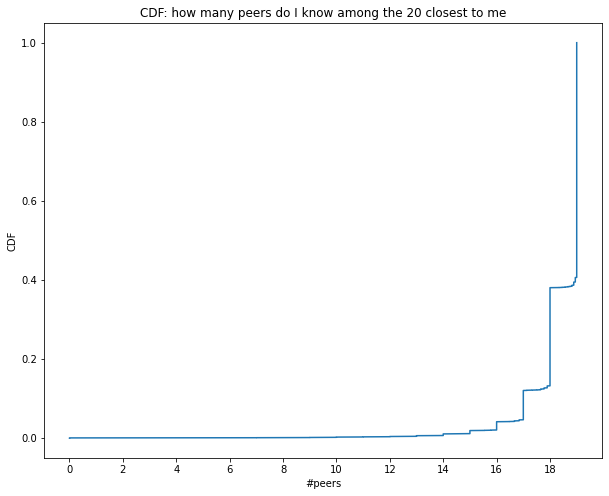

In [217]:
x = np.sort([20*r for r in ratio])
fig = plt.figure(figsize=(10,8))
plt.xticks(np.arange(0, 21, 2))

#calculate CDF values
y = 1. * np.arange(len(ratio)) / (len(ratio) - 1)

#plot CDF
plt.plot(x, y)
plt.xlabel('#peers')
plt.ylabel('CDF')
plt.title('CDF: how many peers do I know among the 20 closest to me')

In [24]:
levels=8
density=[0]*2**levels

In [25]:
for i in range(2**levels):
    path="{0:b}".format(i)
    path='0'*(levels-len(path))+path
    density[i]=t.find(path).size if t.find(path) is not None else 0

AttributeError: 'str' object has no attribute 'bitAt'

In [57]:
print(sum(density))

30453


In [61]:
print(min(density),sum(density)/len(density),max(density))
print(density)

87 118.95703125 232
[123, 111, 126, 100, 122, 106, 135, 107, 116, 126, 97, 108, 112, 137, 88, 98, 122, 117, 128, 110, 114, 126, 109, 134, 111, 137, 125, 104, 114, 134, 118, 109, 118, 111, 108, 133, 138, 108, 122, 115, 113, 120, 125, 108, 132, 122, 128, 119, 107, 133, 104, 126, 121, 120, 100, 127, 127, 125, 118, 104, 121, 131, 126, 103, 109, 115, 114, 120, 135, 121, 93, 125, 133, 115, 118, 150, 104, 132, 118, 114, 118, 125, 101, 138, 111, 106, 102, 97, 120, 136, 139, 123, 119, 106, 134, 108, 125, 101, 115, 118, 117, 107, 127, 132, 101, 119, 106, 132, 113, 108, 120, 114, 90, 96, 106, 140, 113, 103, 113, 115, 104, 120, 117, 121, 100, 125, 138, 111, 115, 129, 97, 113, 115, 106, 140, 129, 127, 118, 116, 121, 133, 119, 111, 113, 127, 109, 103, 128, 127, 114, 106, 128, 112, 109, 106, 133, 134, 130, 119, 125, 121, 113, 112, 111, 104, 90, 122, 89, 142, 131, 109, 102, 116, 114, 122, 108, 133, 232, 104, 121, 104, 103, 87, 116, 102, 126, 127, 114, 132, 91, 120, 140, 132, 126, 125, 121, 127, 122, 1

<BarContainer object of 256 artists>

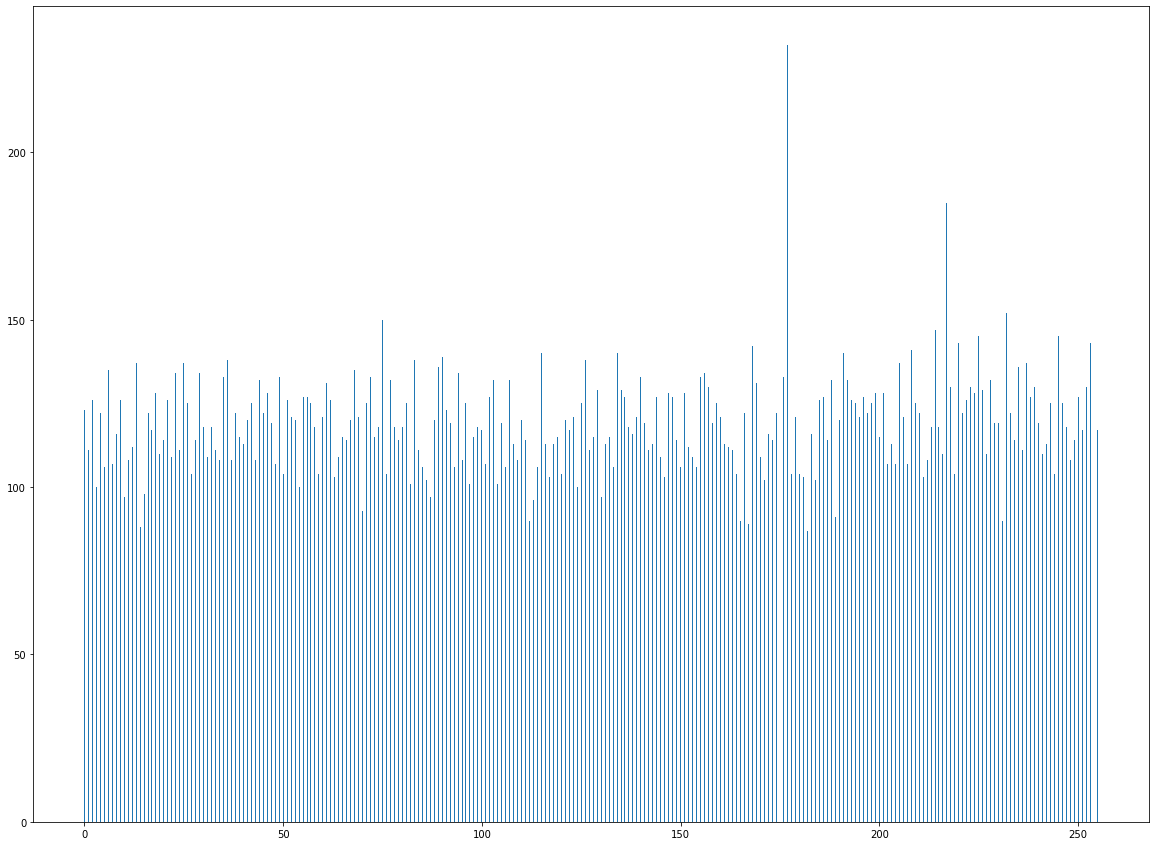

In [84]:
fig = plt.figure(figsize=(20,15))

plt.bar([x for x in range(len(density))], density, width=0.25)

In [26]:
from binary_trie import Trie, bytes_to_bitstring, bitstring_to_bytes, int_to_bitstring, bitstring_to_int


In [28]:
t = Trie()
for p in peers:
    print(p)
    t.add(p)


nebula_id: 1, peer_id: QmbLHAnMoJPWSCR5Zhtx6BHJX9KiKNN6tpvbUcqanj75Nb, neighbors: ['13', '413', '988', '573', '664', '1295', '534', '1087', '1890', '35', '596', '433', '720', '307', '1419', '145', '6745', '523', '38', '22826', '266', '493', '2079', '1444', '19', '1006', '23018', '296', '9', '5', '921', '683', '436', '375', '440', '521', '303', '360', '439', '1166', '1145', '1143', '1038', '1345', '334', '330', '622', '322', '1067', '924', '6359', '517', '39', '740', '183', '530', '280', '1013', '407', '29', '1524', '40', '968', '1128', '311', '465', '405', '582', '3801', '2179', '309', '342', '354', '251', '554', '1269', '947', '885', '34', '1115', '859', '351', '496', '25', '41', '151', '780', '290', '1399', '3803', '343', '2017', '592', '112', '1603', '522', '1385', '6358', '536', '324', '6657', '4495', '1183', '779', '437', '335', '278', '33', '778', '22', '18', '1804', '418', '4671', '603', '27', '458', '284', '20', '416', '1954', '848', '434', '1957', '273', '1490', '1326', '1600'

TypeError: 'NebulaPeer' object is not subscriptable